In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR


In [2]:
train_data_dir = 'category_train'
categories = os.listdir(train_data_dir)
print(categories)

['Dress', 'Jacket', 'Jeans', 'Shoes', 'Sweater', 'T-shirt']


In [3]:
num_labels = len(categories)

category_to_label = {
    colour: idx for idx, colour in enumerate(categories)
}

label_to_category = {
    idx: colour for idx, colour in enumerate(categories)
}

print(num_labels)
print(category_to_label)
print(label_to_category)


6
{'Dress': 0, 'Jacket': 1, 'Jeans': 2, 'Shoes': 3, 'Sweater': 4, 'T-shirt': 5}
{0: 'Dress', 1: 'Jacket', 2: 'Jeans', 3: 'Shoes', 4: 'Sweater', 5: 'T-shirt'}


In [4]:
def random_pick() -> tuple[np.ndarray, int]:
    category = random.choice(categories)
    img_fnames = os.listdir(f'{train_data_dir}/{category}')
    img_path = f'{train_data_dir}/{category}/{random.choice(img_fnames)}'

    img = Image.open(img_path).convert('RGB')
    img = np.asarray(img)
    label = category_to_label[category]
    return img, label

image_shape=(225, 225, 3)


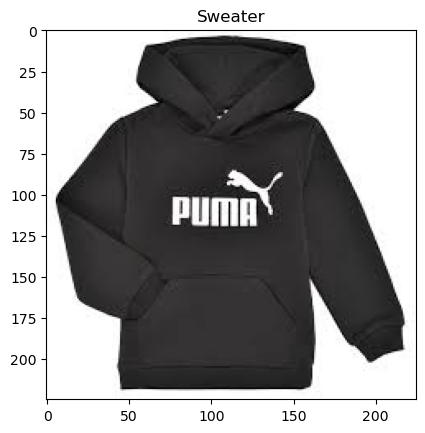

In [67]:
img, label = random_pick()
print(f'image_shape={img.shape}')
plt.imshow(img)
plt.title(label_to_category[label])
plt.show()

In [68]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [69]:
# create a class to preload the images and transform for pytorch processing

class ImageLoader:
    def __init__(self):
        self.transform = transforms.Compose( # chain sequence of image transformations together
            [
                transforms.Resize((224, 224)), # resize it to a square of 224x224
                transforms.ToTensor(), # converts this to a pytorch tensor; these tensors are pivotal to pytorch neural networking
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # normalizes the pixel value of the image
            ]
        )
        
    def load(self, img_path): # uses Python Imaging Library (PIL) to open image
        img = Image.open(img_path).convert('RGB') # open image and convert to RGB
        t_img = self.transform(img) # transform the image defined above
        return t_img

In [70]:
class ImageDataset(Dataset):

    train_data_dir = 'category_train'

    def __init__ (self, image_loader):
        categories = os.listdir(self.train_data_dir)

        self.data = []

        for category in tqdm(categories):
            image_fnames = [i for i in os.listdir(f'{self.train_data_dir}/{category}') if not i.startswith('.')]
            for image_fname in image_fnames:
                img_path = f'{self.train_data_dir}/{category}/{image_fname}'
                t_img = image_loader.load(img_path)
                label = category_to_label[category]
                self.data.append((img_path, t_img, label))

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]


In [71]:
dataset = ImageDataset(ImageLoader())

100%|██████████| 6/6 [00:02<00:00,  2.43it/s]


In [72]:
dataset[0][1].shape

torch.Size([3, 224, 224])

In [73]:
val_ratio = 0.2
test_size = 30

val_size = int(len(dataset) * val_ratio)
train_size = len(dataset) - (val_size + test_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size]) # X_train, y_train, ytest



In [74]:
len(dataset)

246

In [75]:
print(f'train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}')

train: 167, val: 49, test: 30


In [76]:
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validation_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = test_size, shuffle = True)

In [77]:
import torch.nn as nn

In [91]:
class CategoryClassifier(nn.Module):
    def __init__(self):
        super(CategoryClassifier, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1), # (224 - 4 + 2 * 1) / 2 + 1 = 112
            nn.MaxPool2d(kernel_size=4, stride=4), # (112 - 4) / 4 + 1 = 28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=2, stride=2, padding=1), # (28 - 2 + 2 * 1) / 2 + 1 = 15
            nn.MaxPool2d(kernel_size=3, stride=3), # (15 - 3) / 3 + 1 = 5
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=2, stride=1, padding=1), # (5 - 2 + 2 * 1) / 1 + 1 = 6
            nn.MaxPool2d(kernel_size=6, stride=1), # (6 - 6) / 1 + 1 = 1
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout2d(0.3),
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 1, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, num_labels)
        )


        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        return x

In [92]:
model = CategoryClassifier().to(device)

In [93]:
from torchsummary import summary

summary(model, (3, 224, 224))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
         MaxPool2d-2           [-1, 64, 28, 28]               0
       BatchNorm2d-3           [-1, 64, 28, 28]             128
              ReLU-4           [-1, 64, 28, 28]               0
         Dropout2d-5           [-1, 64, 28, 28]               0
            Conv2d-6          [-1, 128, 15, 15]          32,896
         MaxPool2d-7            [-1, 128, 5, 5]               0
       BatchNorm2d-8            [-1, 128, 5, 5]             256
              ReLU-9            [-1, 128, 5, 5]               0
        Dropout2d-10            [-1, 128, 5, 5]               0
           Conv2d-11            [-1, 256, 6, 6]         131,328
        MaxPool2d-12            [-1, 256, 1, 1]               0
      BatchNorm2d-13            [-1, 256, 1, 1]             512
             ReLU-14            [-1, 25

In [94]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)


In [95]:
def train(model, criterion, optimizer, data_loader):
    model.train()
    train_loss, total, corrects = 0, 0, 0
    for _, inputs, labels in tqdm(data_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        
        preds = outputs.argmax(dim=1)
        total += len(inputs)
        corrects += (preds == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    train_loss /= len(data_loader)
    train_accuracy = corrects / total
    
    return train_loss, train_accuracy

def evaluate(model, criterion, data_loader):
    model.eval()
    val_loss, total, corrects = 0, 0, 0
    with torch.no_grad():
        for _, inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            total += len(inputs)
            corrects += (preds == labels).sum().item()
    
    val_loss /= len(data_loader)
    val_accuracy = corrects / total   
    
    return val_loss, val_accuracy

In [96]:
epochs = 200

#scheduler = StepLR(optimizer, step_size = 150, gamma = 0.1) # decrease epoch by 0.1 every 50 steps

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(epochs):
    train_loss, train_accuracy = train(model, criterion, optimizer, train_loader)
    val_loss, val_accuracy = evaluate(model, criterion, validation_loader)

    #scheduler.step()
    
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'epoch={epoch + 1}, train_loss={train_loss:.3f}, val_loss={val_loss:.3f}, train_accuracy={train_accuracy:.3f}, val_accuracy={val_accuracy:.3f}')

100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=1, train_loss=1.780, val_loss=1.788, train_accuracy=0.210, val_accuracy=0.163


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=2, train_loss=1.745, val_loss=1.783, train_accuracy=0.186, val_accuracy=0.163


100%|██████████| 3/3 [00:00<00:00,  4.96it/s]


epoch=3, train_loss=1.724, val_loss=1.783, train_accuracy=0.174, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  4.56it/s]


epoch=4, train_loss=1.730, val_loss=1.782, train_accuracy=0.174, val_accuracy=0.286


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=5, train_loss=1.712, val_loss=1.781, train_accuracy=0.222, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=6, train_loss=1.709, val_loss=1.778, train_accuracy=0.234, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=7, train_loss=1.693, val_loss=1.774, train_accuracy=0.287, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=8, train_loss=1.658, val_loss=1.769, train_accuracy=0.341, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


epoch=9, train_loss=1.614, val_loss=1.764, train_accuracy=0.413, val_accuracy=0.245


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]


epoch=10, train_loss=1.640, val_loss=1.753, train_accuracy=0.365, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


epoch=11, train_loss=1.570, val_loss=1.736, train_accuracy=0.383, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=12, train_loss=1.543, val_loss=1.720, train_accuracy=0.413, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=13, train_loss=1.548, val_loss=1.700, train_accuracy=0.371, val_accuracy=0.204


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=14, train_loss=1.441, val_loss=1.710, train_accuracy=0.431, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  5.23it/s]


epoch=15, train_loss=1.401, val_loss=1.727, train_accuracy=0.497, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]


epoch=16, train_loss=1.450, val_loss=1.714, train_accuracy=0.467, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=17, train_loss=1.441, val_loss=1.682, train_accuracy=0.437, val_accuracy=0.347


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


epoch=18, train_loss=1.410, val_loss=1.718, train_accuracy=0.443, val_accuracy=0.265


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=19, train_loss=1.282, val_loss=1.799, train_accuracy=0.491, val_accuracy=0.143


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=20, train_loss=1.298, val_loss=1.758, train_accuracy=0.503, val_accuracy=0.163


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=21, train_loss=1.227, val_loss=1.717, train_accuracy=0.551, val_accuracy=0.224


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=22, train_loss=1.227, val_loss=1.690, train_accuracy=0.557, val_accuracy=0.204


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=23, train_loss=1.120, val_loss=1.743, train_accuracy=0.575, val_accuracy=0.184


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=24, train_loss=1.176, val_loss=1.823, train_accuracy=0.575, val_accuracy=0.204


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


epoch=25, train_loss=1.083, val_loss=1.816, train_accuracy=0.629, val_accuracy=0.245


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]


epoch=26, train_loss=1.065, val_loss=1.766, train_accuracy=0.617, val_accuracy=0.265


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


epoch=27, train_loss=0.952, val_loss=1.762, train_accuracy=0.659, val_accuracy=0.265


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=28, train_loss=1.004, val_loss=1.805, train_accuracy=0.647, val_accuracy=0.306


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=29, train_loss=0.956, val_loss=1.859, train_accuracy=0.665, val_accuracy=0.306


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=30, train_loss=0.880, val_loss=1.880, train_accuracy=0.713, val_accuracy=0.265


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=31, train_loss=0.842, val_loss=1.896, train_accuracy=0.707, val_accuracy=0.265


100%|██████████| 3/3 [00:00<00:00,  4.88it/s]


epoch=32, train_loss=0.830, val_loss=1.906, train_accuracy=0.653, val_accuracy=0.327


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=33, train_loss=0.771, val_loss=1.824, train_accuracy=0.790, val_accuracy=0.347


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]


epoch=34, train_loss=0.765, val_loss=1.745, train_accuracy=0.749, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=35, train_loss=0.766, val_loss=1.721, train_accuracy=0.731, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=36, train_loss=0.655, val_loss=1.727, train_accuracy=0.737, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


epoch=37, train_loss=0.569, val_loss=1.693, train_accuracy=0.814, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=38, train_loss=0.620, val_loss=1.726, train_accuracy=0.749, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=39, train_loss=0.576, val_loss=1.754, train_accuracy=0.796, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=40, train_loss=0.634, val_loss=1.610, train_accuracy=0.766, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=41, train_loss=0.551, val_loss=1.545, train_accuracy=0.796, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


epoch=42, train_loss=0.502, val_loss=1.608, train_accuracy=0.844, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=43, train_loss=0.540, val_loss=1.727, train_accuracy=0.844, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=44, train_loss=0.465, val_loss=1.800, train_accuracy=0.850, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=45, train_loss=0.492, val_loss=1.772, train_accuracy=0.850, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=46, train_loss=0.436, val_loss=1.822, train_accuracy=0.874, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=47, train_loss=0.511, val_loss=1.906, train_accuracy=0.820, val_accuracy=0.347


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=48, train_loss=0.430, val_loss=1.901, train_accuracy=0.856, val_accuracy=0.367


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=49, train_loss=0.432, val_loss=1.773, train_accuracy=0.862, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.53it/s]


epoch=50, train_loss=0.317, val_loss=1.668, train_accuracy=0.904, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.11it/s]


epoch=51, train_loss=0.399, val_loss=1.603, train_accuracy=0.862, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=52, train_loss=0.354, val_loss=1.604, train_accuracy=0.850, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=53, train_loss=0.390, val_loss=1.743, train_accuracy=0.850, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=54, train_loss=0.461, val_loss=1.864, train_accuracy=0.838, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=55, train_loss=0.331, val_loss=1.917, train_accuracy=0.910, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=56, train_loss=0.311, val_loss=1.922, train_accuracy=0.892, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=57, train_loss=0.254, val_loss=1.885, train_accuracy=0.910, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  4.60it/s]


epoch=58, train_loss=0.295, val_loss=1.808, train_accuracy=0.922, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=59, train_loss=0.302, val_loss=1.758, train_accuracy=0.904, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


epoch=60, train_loss=0.392, val_loss=1.799, train_accuracy=0.892, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=61, train_loss=0.332, val_loss=1.836, train_accuracy=0.898, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=62, train_loss=0.255, val_loss=1.823, train_accuracy=0.916, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=63, train_loss=0.180, val_loss=1.801, train_accuracy=0.952, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=64, train_loss=0.143, val_loss=1.919, train_accuracy=0.958, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=65, train_loss=0.211, val_loss=1.999, train_accuracy=0.928, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.59it/s]


epoch=66, train_loss=0.314, val_loss=2.026, train_accuracy=0.898, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.21it/s]


epoch=67, train_loss=0.182, val_loss=2.123, train_accuracy=0.922, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


epoch=68, train_loss=0.274, val_loss=2.238, train_accuracy=0.910, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=69, train_loss=0.186, val_loss=2.303, train_accuracy=0.958, val_accuracy=0.367


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=70, train_loss=0.171, val_loss=2.290, train_accuracy=0.946, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


epoch=71, train_loss=0.287, val_loss=2.244, train_accuracy=0.910, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


epoch=72, train_loss=0.235, val_loss=2.110, train_accuracy=0.916, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  4.97it/s]


epoch=73, train_loss=0.133, val_loss=2.076, train_accuracy=0.952, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.85it/s]


epoch=74, train_loss=0.157, val_loss=2.111, train_accuracy=0.946, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=75, train_loss=0.226, val_loss=2.100, train_accuracy=0.934, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=76, train_loss=0.218, val_loss=2.040, train_accuracy=0.934, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=77, train_loss=0.094, val_loss=1.970, train_accuracy=0.976, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


epoch=78, train_loss=0.144, val_loss=2.022, train_accuracy=0.970, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


epoch=79, train_loss=0.231, val_loss=2.126, train_accuracy=0.934, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=80, train_loss=0.125, val_loss=2.221, train_accuracy=0.958, val_accuracy=0.306


100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


epoch=81, train_loss=0.087, val_loss=2.147, train_accuracy=0.976, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


epoch=82, train_loss=0.134, val_loss=2.040, train_accuracy=0.958, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=83, train_loss=0.120, val_loss=1.935, train_accuracy=0.964, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.07it/s]


epoch=84, train_loss=0.151, val_loss=1.901, train_accuracy=0.952, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=85, train_loss=0.201, val_loss=1.863, train_accuracy=0.946, val_accuracy=0.571


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=86, train_loss=0.117, val_loss=1.865, train_accuracy=0.970, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=87, train_loss=0.173, val_loss=1.924, train_accuracy=0.934, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  4.18it/s]


epoch=88, train_loss=0.149, val_loss=1.967, train_accuracy=0.940, val_accuracy=0.531


100%|██████████| 3/3 [00:00<00:00,  4.89it/s]


epoch=89, train_loss=0.150, val_loss=2.116, train_accuracy=0.928, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


epoch=90, train_loss=0.108, val_loss=2.171, train_accuracy=0.970, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.06it/s]


epoch=91, train_loss=0.141, val_loss=2.200, train_accuracy=0.946, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.51it/s]


epoch=92, train_loss=0.152, val_loss=2.188, train_accuracy=0.940, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=93, train_loss=0.080, val_loss=2.152, train_accuracy=0.976, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


epoch=94, train_loss=0.189, val_loss=2.145, train_accuracy=0.970, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  4.27it/s]


epoch=95, train_loss=0.090, val_loss=2.120, train_accuracy=0.976, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.86it/s]


epoch=96, train_loss=0.088, val_loss=2.110, train_accuracy=0.970, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.90it/s]


epoch=97, train_loss=0.141, val_loss=2.162, train_accuracy=0.952, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=98, train_loss=0.066, val_loss=2.193, train_accuracy=0.976, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.00it/s]


epoch=99, train_loss=0.137, val_loss=2.176, train_accuracy=0.964, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=100, train_loss=0.150, val_loss=2.168, train_accuracy=0.940, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.09it/s]


epoch=101, train_loss=0.131, val_loss=2.213, train_accuracy=0.958, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.52it/s]


epoch=102, train_loss=0.107, val_loss=2.206, train_accuracy=0.976, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=103, train_loss=0.049, val_loss=2.271, train_accuracy=0.994, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=104, train_loss=0.156, val_loss=2.308, train_accuracy=0.952, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=105, train_loss=0.083, val_loss=2.339, train_accuracy=0.976, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.01it/s]


epoch=106, train_loss=0.250, val_loss=2.355, train_accuracy=0.910, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.10it/s]


epoch=107, train_loss=0.185, val_loss=2.373, train_accuracy=0.922, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=108, train_loss=0.154, val_loss=2.431, train_accuracy=0.946, val_accuracy=0.327


100%|██████████| 3/3 [00:00<00:00,  4.68it/s]


epoch=109, train_loss=0.149, val_loss=2.387, train_accuracy=0.952, val_accuracy=0.327


100%|██████████| 3/3 [00:00<00:00,  5.24it/s]


epoch=110, train_loss=0.095, val_loss=2.408, train_accuracy=0.964, val_accuracy=0.327


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=111, train_loss=0.053, val_loss=2.383, train_accuracy=0.982, val_accuracy=0.367


100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


epoch=112, train_loss=0.106, val_loss=2.365, train_accuracy=0.982, val_accuracy=0.367


100%|██████████| 3/3 [00:00<00:00,  4.66it/s]


epoch=113, train_loss=0.075, val_loss=2.356, train_accuracy=0.976, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.64it/s]


epoch=114, train_loss=0.120, val_loss=2.330, train_accuracy=0.964, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


epoch=115, train_loss=0.095, val_loss=2.244, train_accuracy=0.982, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=116, train_loss=0.072, val_loss=2.247, train_accuracy=0.988, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.46it/s]


epoch=117, train_loss=0.137, val_loss=2.279, train_accuracy=0.964, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=118, train_loss=0.037, val_loss=2.313, train_accuracy=0.994, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=119, train_loss=0.052, val_loss=2.324, train_accuracy=0.988, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  4.80it/s]


epoch=120, train_loss=0.072, val_loss=2.239, train_accuracy=0.976, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  4.99it/s]


epoch=121, train_loss=0.073, val_loss=2.210, train_accuracy=0.976, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  4.93it/s]


epoch=122, train_loss=0.128, val_loss=2.074, train_accuracy=0.970, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=123, train_loss=0.073, val_loss=1.960, train_accuracy=0.982, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=124, train_loss=0.069, val_loss=1.899, train_accuracy=0.976, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=125, train_loss=0.067, val_loss=1.847, train_accuracy=0.988, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.91it/s]


epoch=126, train_loss=0.115, val_loss=1.837, train_accuracy=0.952, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=127, train_loss=0.113, val_loss=1.935, train_accuracy=0.958, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.16it/s]


epoch=128, train_loss=0.094, val_loss=2.180, train_accuracy=0.970, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.08it/s]


epoch=129, train_loss=0.101, val_loss=2.451, train_accuracy=0.982, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.03it/s]


epoch=130, train_loss=0.082, val_loss=2.461, train_accuracy=0.970, val_accuracy=0.388


100%|██████████| 3/3 [00:00<00:00,  5.20it/s]


epoch=131, train_loss=0.100, val_loss=2.336, train_accuracy=0.988, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  4.58it/s]


epoch=132, train_loss=0.084, val_loss=2.292, train_accuracy=0.982, val_accuracy=0.429


100%|██████████| 3/3 [00:00<00:00,  5.05it/s]


epoch=133, train_loss=0.157, val_loss=2.301, train_accuracy=0.946, val_accuracy=0.408


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


epoch=134, train_loss=0.127, val_loss=2.249, train_accuracy=0.958, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=135, train_loss=0.183, val_loss=2.170, train_accuracy=0.946, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=136, train_loss=0.057, val_loss=2.088, train_accuracy=0.982, val_accuracy=0.449


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch=137, train_loss=0.065, val_loss=2.018, train_accuracy=0.982, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


epoch=138, train_loss=0.056, val_loss=1.873, train_accuracy=0.982, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


epoch=139, train_loss=0.153, val_loss=1.804, train_accuracy=0.952, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=140, train_loss=0.106, val_loss=1.762, train_accuracy=0.964, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


epoch=141, train_loss=0.050, val_loss=1.755, train_accuracy=0.988, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=142, train_loss=0.146, val_loss=1.805, train_accuracy=0.970, val_accuracy=0.531


100%|██████████| 3/3 [00:00<00:00,  5.13it/s]


epoch=143, train_loss=0.065, val_loss=1.854, train_accuracy=0.976, val_accuracy=0.531


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


epoch=144, train_loss=0.043, val_loss=1.876, train_accuracy=0.988, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


epoch=145, train_loss=0.023, val_loss=1.897, train_accuracy=0.994, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


epoch=146, train_loss=0.059, val_loss=1.915, train_accuracy=0.988, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.17it/s]


epoch=147, train_loss=0.101, val_loss=1.942, train_accuracy=0.964, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.04it/s]


epoch=148, train_loss=0.139, val_loss=1.969, train_accuracy=0.958, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  5.22it/s]


epoch=149, train_loss=0.045, val_loss=2.033, train_accuracy=0.982, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.15it/s]


epoch=150, train_loss=0.045, val_loss=2.075, train_accuracy=0.982, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=151, train_loss=0.088, val_loss=2.028, train_accuracy=0.970, val_accuracy=0.469


100%|██████████| 3/3 [00:00<00:00,  4.98it/s]


epoch=152, train_loss=0.052, val_loss=1.960, train_accuracy=0.988, val_accuracy=0.490


100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


epoch=153, train_loss=0.198, val_loss=1.939, train_accuracy=0.946, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.02it/s]


epoch=154, train_loss=0.032, val_loss=1.890, train_accuracy=0.988, val_accuracy=0.531


100%|██████████| 3/3 [00:00<00:00,  4.87it/s]


epoch=155, train_loss=0.038, val_loss=1.867, train_accuracy=0.994, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  4.94it/s]


epoch=156, train_loss=0.024, val_loss=1.865, train_accuracy=0.988, val_accuracy=0.510


100%|██████████| 3/3 [00:00<00:00,  5.18it/s]


epoch=157, train_loss=0.055, val_loss=1.840, train_accuracy=0.976, val_accuracy=0.510


  0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

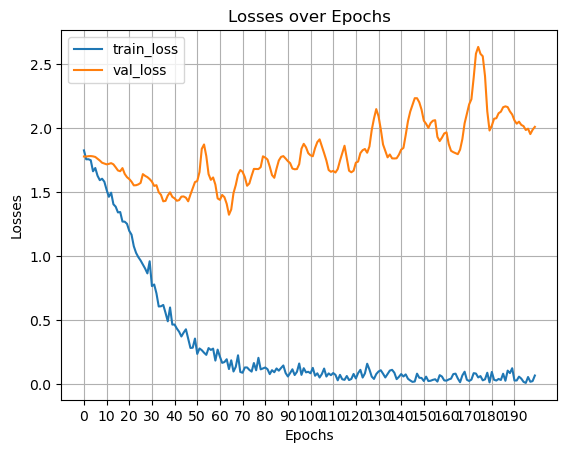

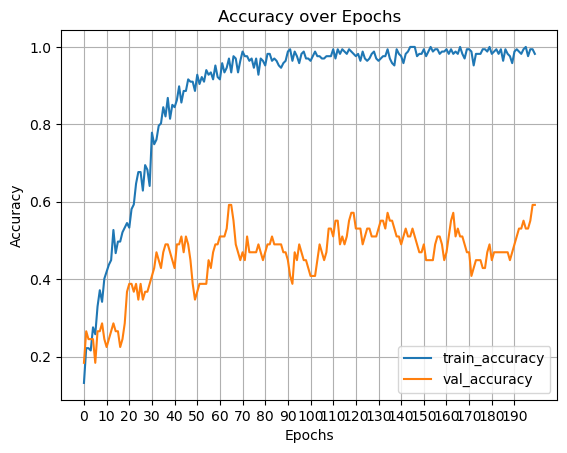

In [84]:
def plot_metrics(epochs, train_metric, val_metric, metric_name, ylabel, title):
    plt.plot(range(epochs), train_metric)
    plt.plot(range(epochs), val_metric)
    plt.legend([f'train_{metric_name}', f'val_{metric_name}'])
    plt.xticks(range(0, epochs, 10))
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.show()

# Example usage for losses
plot_metrics(epochs, train_losses, val_losses, 'loss', 'Losses', 'Losses over Epochs')

# Example usage for accuracies
plot_metrics(epochs, train_accuracies, val_accuracies, 'accuracy', 'Accuracy', 'Accuracy over Epochs')

In [28]:
from torch.utils.data import Subset

sample_data = Subset(test_dataset, range(10))
sample_loader = DataLoader(sample_data, batch_size=30)

In [29]:
import math

def plot_images(model, img_paths, t_imgs, labels = None):
    _, axes = plt.subplots(
        math.ceil(len(img_paths) / 5),
        5,
        figsize=(15, 5 * math.ceil(len(img_paths) / 5)),
    )
    plt.tick_params(left=False, right=False, bottom=False)
    outputs = model(t_imgs.to(device))
    outputs = torch.softmax(outputs, dim=1)

    preds = outputs.argmax(1)
    best_indices = outputs.argsort(dim=1, descending=True)

    axes = np.reshape(axes, (math.ceil(len(img_paths) / 5), 5))  # Reshape axes array
    
    for i in range(len(preds)):
        img = Image.open(img_paths[i]).convert('RGB')
        axes[i // 5, i % 5].imshow(img)
        axes[i // 5, i % 5].set_xticks([])
        axes[i // 5, i % 5].set_yticks([])
        
        best_idx0 = best_indices[i][0].item()
        best_idx1 = best_indices[i][1].item()
        title = ''
        if labels is not None:
            title += f'Actual Category: {label_to_category[labels[i].item()]}\n'
        title += '-' * 20 + '\n'
        title += f"Predicted {label_to_category[best_idx0]}: {outputs[i, best_idx0]*100:.2f}%\n"
        title += f"Predicted {label_to_category[best_idx1]}: {outputs[i, best_idx1]*100:.2f}%\n"
        axes[i // 5, i % 5].set_title(title)

    plt.show()

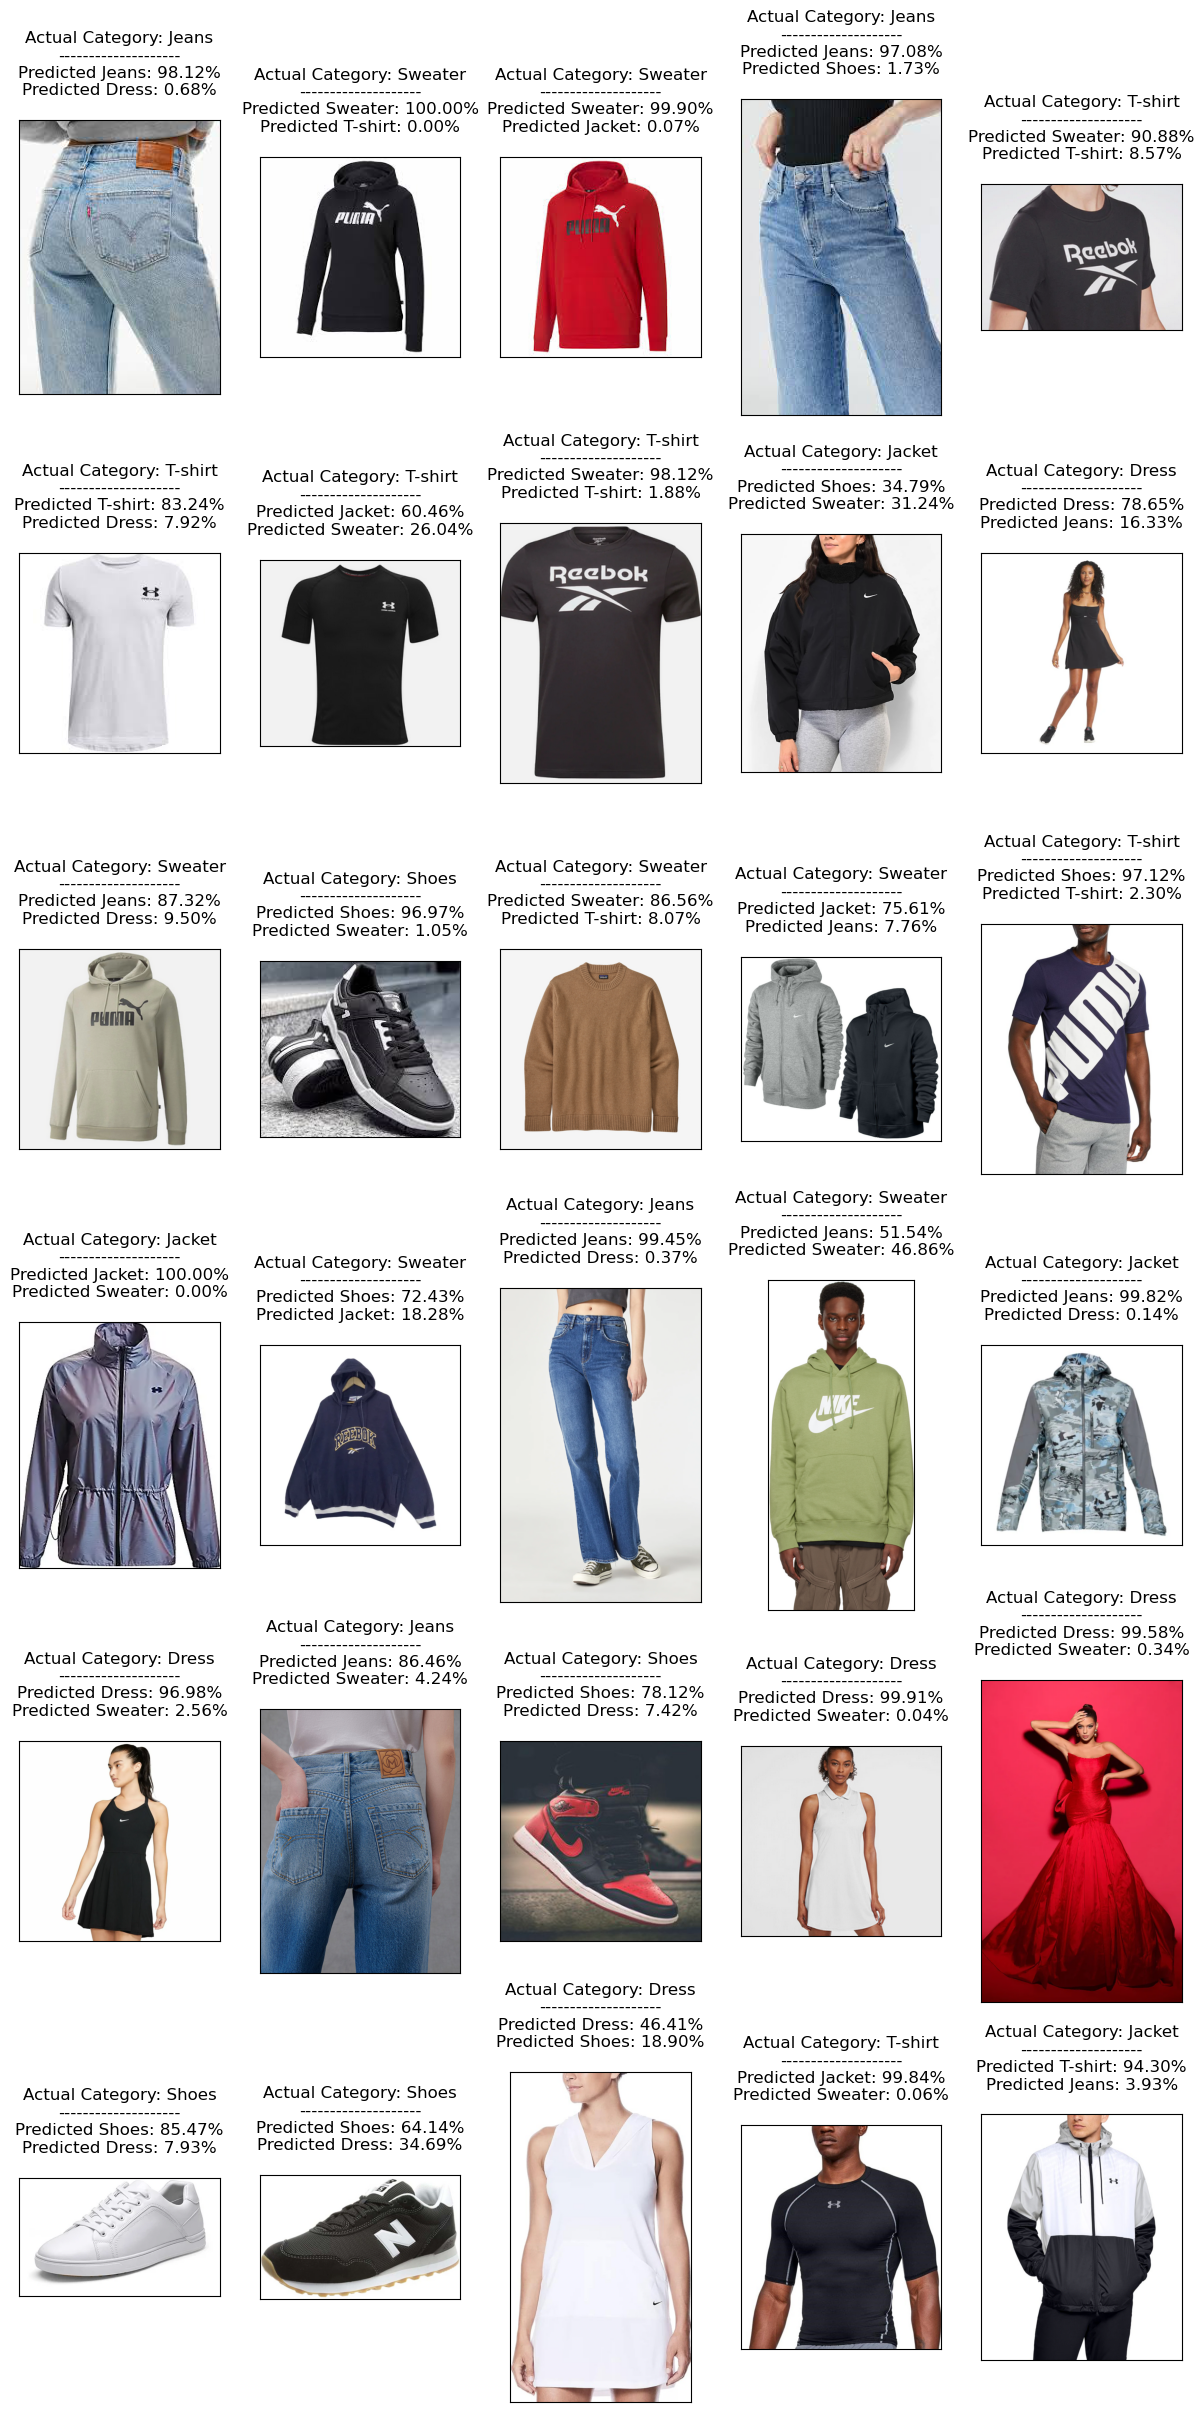

In [30]:
with torch.no_grad():
    for img_paths, t_imgs, labels in test_loader:
        plot_images(model, img_paths, t_imgs, labels)